# Constrained optimization

## SQP with equality constraints

In [193]:
import numpy as np

class SQP():
    
    def __init__(self, X0, L0, max_iterations, eps):
        self.X0 = np.array(X0)
        self.L0 = np.array(L0)
        self.max_iterations = max_iterations
        self.eps = eps
        
    def solve(self, f, f_grad, f_hess, eq, eq_jaco, eq_hess):
        
        X, L = self.X0.copy(), self.L0.copy()
        p, q = X.size, L.size
        trace = [X.copy()]
        
        for _ in range(self.max_iterations):
    
            # Compute the gradient
            gradient = np.zeros((p + q))
            gradient[:p] = f_grad(X) + L * eq_jaco(X)
            gradient[p:] = eq(X)

            # Stop if the norm of the gradient is too low
            if np.linalg.norm(gradient) < self.eps:
                break

            # Compute the Hessian
            hessian = np.zeros((p+q, p+q))
            hessian[0:p,0:p] = f_hess(X) + (L * eq_hess(X)).sum(axis=2)
            hessian[p:p+q,0:p] = eq_jaco(X)
            hessian[0:p,p:p+q] = hessian[p:p+q,0:p].T
            
            # Estimate the descent direction
            direction = np.linalg.solve(hessian, -gradient)

            # Move X and L along the descent direction
            X = X + direction[:p]
            L = L + direction[p:]

            # Store the new position and the new step size 
            trace.append(X.copy())
            
        return np.array(trace)

## Examples

### Sphere function

In [194]:
def f(X):
    return X[0] + X[1]

def f_grad(X):
    return np.array([1, 1])

def f_hess(X):
    return np.zeros((2, 2))

def eq(X):
    return X[0] ** 2 + (X[1] - 1) ** 2 - 1

def eq_jaco(X):
    Jh = np.zeros((1, 2))
    Jh[0,0] = 2 * X[0]
    Jh[0,1] = 2 * (X[1] - 1)
    return Jh

def eq_hess(X):
    Jh = np.zeros((2, 2, 1))
    Jh[0, 0, 0] = 2
    Jh[1, 1, 0] = 2
    return Jh

trace = SQP([1., -1.], [1.], 20, 1e-15).solve(f, f_grad, f_hess, eq, eq_jaco, eq_hess)
trace

array([[ 1.        , -1.        ],
       [ 0.        , -0.5       ],
       [-1.        , -0.08333333],
       [-0.77400864,  0.24972593],
       [-0.70742509,  0.28899696],
       [-0.70713502,  0.29291057],
       [-0.70710678,  0.29289322],
       [-0.70710678,  0.29289322]])

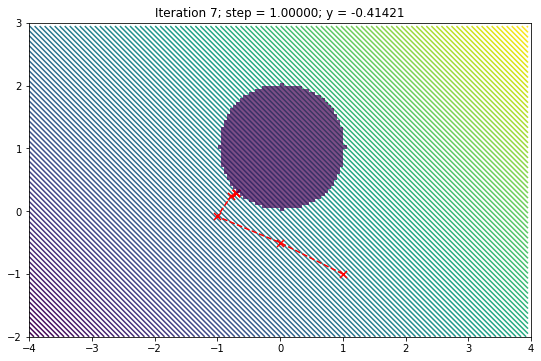

In [195]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_contour(a, b, c, d, f, eq, ax):
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta)) 
    
    # Plot the contour line
    ax.contour(x0, x1, f([x0, x1]), 200, zorder=0)
    
    # Plot the constraint region
    region = eq([x0, x1]) < 1e-10
    mask = np.ma.masked_where(~region, np.ones_like(region))
    ax.imshow(mask, origin='lower', extent=(a, b, c, d), alpha=0.7, zorder=1)


def plot_trace(trace, steps, f, ax):
    ax.plot(trace[:, 0], trace[:, 1], color='red', linestyle='--')
    for i, (x0, x1) in enumerate(trace):
        ax.scatter(x0, x1, color='red', marker='x', s=50)
        ax.set_title('Iteration {}; step = {:.5f}; y = {:.5f}'.format(i, steps[i], f((x0, x1))))
        fig.canvas.draw()
        
        
fig, ax = plt.subplots(figsize=(9, 6))
plot_contour(-4, 4, -2, 3, f, eq, ax)
plot_trace(trace, steps, f, ax)

### Rosenbrock function

In [197]:
def f(X, a=1, b=1):
    (x0, x1) = X
    return (x0 - a) ** 2 + b * (x0 ** 2 - x1) ** 2

def f_grad(X, a=1, b=1):
    (x0, x1) = X
    dx0 = 2*(x0-a) + 4*b*x0 * (x0**2-x1)
    dx1 = -2*b * (x0**2 - x1)
    return np.array([dx0, dx1])

def f_hess(X, a=1, b=1):
    (x0, x1) = X
    dx0x0 = 2 + 4*b* (x0*x0 - x1) + 8*b*x0*x0
    dx0x1 = -4*b*x0
    dx1x0 = -4*b*x0
    dx1x1 = 2*b
    return np.array([[dx0x0, dx0x1], [dx1x0, dx1x1]])

def eq(X):
    return X[0] - X[1] ** 2 - 0.5

def eq_jaco(X):
    Jh = np.zeros((1, 2))
    Jh[0,0] = 1.
    Jh[0,1] = -2 * X[1]
    return Jh

def eq_hess(X):
    Jh = np.zeros((2, 2, 1))
    Jh[1, 1, 0] = -2
    return Jh

trace = SQP([-1., 1.], [1.], 3, 1e-5).solve(f, f_grad, f_hess, eq, eq_jaco, eq_hess)
trace

array([[-1.        ,  1.        ],
       [-0.35714286,  0.07142857],
       [ 2.15389332, 11.6129675 ],
       [ 3.95679376,  5.9553171 ]])

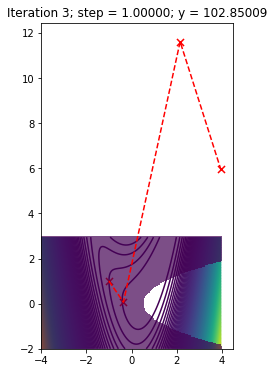

In [198]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_contour(-4, 4, -2, 3, f, eq, ax)
plot_trace(trace, steps, f, ax)

## Inequality constraints